In [2]:
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama

from typing import TypedDict, Annotated
from pydantic import BaseModel, Field
import operator

In [3]:
model=ChatOllama(model='qwen3:8b')

In [5]:
class EvaluationSchema(BaseModel):

    feedback: str = Field(description='Detailed feedbackfor the essay')
    score: int = Field(description='Score out of 10', ge=0, le=10)

In [6]:
structured_model = model.with_structured_output(EvaluationSchema)

In [7]:
essay = """France in the Age of AI
As the world enters a transformative era defined by artificial intelligence (AI), France stands at a critical juncture — one where it can either emerge as a global leader in AI innovation or risk falling behind in the technology race. The age of AI brings with it immense promise as well as unprecedented challenges, and how France navigates this landscape will shape its socio-economic and geopolitical future.

France's strengths in the AI domain are rooted in its vast pool of skilled engineers, a thriving IT industry, and a growing startup ecosystem. With over 5 million STEM graduates annually and a burgeoning base of AI researchers, France possesses the intellectual capital required to build cutting-edge AI systems. Institutions like IITs, IIITs, and IISc have begun fostering AI research, while private players such as TCS, Infosys, and Wipro are integrating AI into their global services. In 2020, the government launched the National AI Strategy (AI for All) with a focus on inclusive growth, aiming to leverage AI in healthcare, agriculture, education, and smart mobility.

One of the most promising applications of AI in France lies in agriculture, where predictive analytics can guide farmers on optimal sowing times, weather forecasts, and pest control. In healthcare, AI-powered diagnostics can help address France’s doctor-patient ratio crisis, particularly in rural areas. Educational platforms are increasingly using AI to personalize learning paths, while smart governance tools are helping improve public service delivery and fraud detection.

However, the path to AI-led growth is riddled with challenges. Chief among them is the digital divide. While metropolitan cities may embrace AI-driven solutions, rural France continues to struggle with basic internet access and digital literacy. The risk of job displacement due to automation also looms large, especially for low-skilled workers. Without effective skilling and re-skilling programs, AI could exacerbate existing socio-economic inequalities.

Another pressing concern is data privacy and ethics. As AI systems rely heavily on vast datasets, ensuring that personal data is used transparently and responsibly becomes vital. France is still shaping its data protection laws, and in the absence of a strong regulatory framework, AI systems may risk misuse or bias.

To harness AI responsibly, France must adopt a multi-stakeholder approach involving the government, academia, industry, and civil society. Policies should promote open datasets, encourage responsible innovation, and ensure ethical AI practices. There is also a need for international collaboration, particularly with countries leading in AI research, to gain strategic advantage and ensure interoperability in global systems.

France’s demographic dividend, when paired with responsible AI adoption, can unlock massive economic growth, improve governance, and uplift marginalized communities. But this vision will only materialize if AI is seen not merely as a tool for automation, but as an enabler of human-centered development.

In conclusion, France in the age of AI is a story in the making — one of opportunity, responsibility, and transformation. The decisions we make today will not just determine France’s AI trajectory, but also its future as an inclusive, equitable, and innovation-driven society."""

In [8]:
prompt = f'Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {essay}'
structured_model.invoke(prompt).feedback

"The essay provides a clear and structured overview of France's potential in the AI era, discussing strengths, applications, challenges, and recommendations. However, there are several issues affecting its language quality and accuracy: 1. **Factual inaccuracies**: The essay incorrectly references Indian institutions (IITs, IIITs, IISc) and companies (TCS, Infosys, Wipro) as part of France's AI ecosystem. These entities are not French, which misrepresents the context. 2. **Repetition and awkward phrasing**: Phrases like 'AI-powered diagnostics' and 'smart governance tools' are repeated or phrased awkwardly (e.g., 'France's demographic dividend, when paired with responsible AI adoption, can unlock massive economic growth...'). 3. **Grammar and punctuation**: Some sentences lack proper punctuation (e.g., missing commas or semicolons) and could be streamlined for clarity. 4. **Flow**: While the structure is logical, the inclusion of irrelevant Indian entities disrupts the flow and focus o

In [9]:
class UPSCState(TypedDict):

    essay: str
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str
    overall_feedback: str
    individual_scores: Annotated[list[int], operator.add]
    avg_score: float

In [10]:
def evaluate_language(state: UPSCState):

    prompt = f'Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output = structured_model.invoke(prompt)

    return {'language_feedback': output.feedback, 'individual_scores': [output.score]}

In [11]:
def evaluate_analysis(state: UPSCState):

    prompt = f'Evaluate the depth of analysis of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output = structured_model.invoke(prompt)

    return {'analysis_feedback': output.feedback, 'individual_scores': [output.score]}

In [12]:
def evaluate_thought(state: UPSCState):

    prompt = f'Evaluate the clarity of thought of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output = structured_model.invoke(prompt)

    return {'clarity_feedback': output.feedback, 'individual_scores': [output.score]}

In [13]:
def final_evaluation(state: UPSCState):

    # summary feedback
    prompt = f'Based on the following feedbacks create a summarized feedback \n language feedback - {state["language_feedback"]} \n depth of analysis feedback - {state["analysis_feedback"]} \n clarity of thought feedback - {state["clarity_feedback"]}'
    overall_feedback = model.invoke(prompt).content

    # avg calculate
    avg_score = sum(state['individual_scores'])/len(state['individual_scores'])

    return {'overall_feedback': overall_feedback, 'avg_score': avg_score}


In [14]:
graph = StateGraph(UPSCState)

graph.add_node('evaluate_language', evaluate_language)
graph.add_node('evaluate_analysis', evaluate_analysis)
graph.add_node('evaluate_thought', evaluate_thought)
graph.add_node('final_evaluation', final_evaluation)

# edges
graph.add_edge(START, 'evaluate_language')
graph.add_edge(START, 'evaluate_analysis')
graph.add_edge(START, 'evaluate_thought')

graph.add_edge('evaluate_language', 'final_evaluation')
graph.add_edge('evaluate_analysis', 'final_evaluation')
graph.add_edge('evaluate_thought', 'final_evaluation')

graph.add_edge('final_evaluation', END)

workflow = graph.compile()

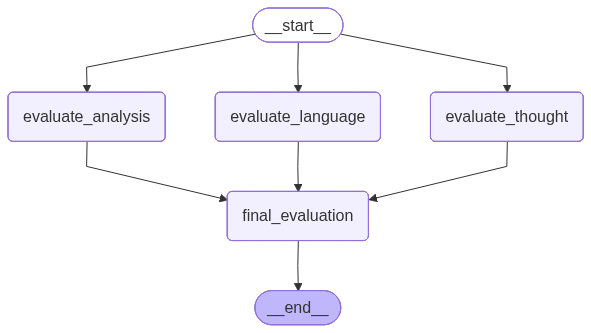

In [15]:

workflow

In [16]:
essay="""France and AI Time is becoming a very important topic in modern society. Artificial Intelligence is changing how people work, learn, and communicate. In France, many companies and universities are investing in AI research to improve healthcare, transportation, and education. For example, AI can help doctors analyze medical images faster and help students learn through personalized online platforms. Because of these developments, AI is seen as a key part of France’s future economy.

However, there are also challenges related to AI Time in France. Some people worry that AI will replace human jobs and increase unemployment. Others are concerned about privacy and data security, since AI systems often collect large amounts of personal information. The French government is trying to create laws to control AI usage and protect citizens, but this process is complex and still ongoing.

In conclusion, France and AI Time represents both opportunities and risks. If managed properly, AI can improve quality of life and make France a global leader in technology. But if it is not controlled, it could create social problems and ethical issues. Therefore, it is important for France to balance innovation with responsibility."""

In [17]:
intial_state = {
    'essay': essay
}

workflow.invoke(intial_state)

{'essay': 'France and AI Time is becoming a very important topic in modern society. Artificial Intelligence is changing how people work, learn, and communicate. In France, many companies and universities are investing in AI research to improve healthcare, transportation, and education. For example, AI can help doctors analyze medical images faster and help students learn through personalized online platforms. Because of these developments, AI is seen as a key part of France’s future economy.\n\nHowever, there are also challenges related to AI Time in France. Some people worry that AI will replace human jobs and increase unemployment. Others are concerned about privacy and data security, since AI systems often collect large amounts of personal information. The French government is trying to create laws to control AI usage and protect citizens, but this process is complex and still ongoing.\n\nIn conclusion, France and AI Time represents both opportunities and risks. If managed properly,